In [1]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt
import transformers

from collections import defaultdict #, Counter
from transformers import AutoModelForMaskedLM, AutoTokenizer

from operator import mul
from functools import reduce

device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

MODEL_NAME = 'xlm-roberta-large'
MASK_TOKEN = '<mask>'
PAD_TOKEN = '<pad>'
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
device = torch.device('cuda:0')
model.to(device)
reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}

In [2]:
# let's check the number of tokens in our keywords
keywords = ['quoi que ce soit', 'qui que ce soit']
keywords2tokens = dict()

for keyword in keywords:
    tokens = tokenizer.tokenize(keyword)
    keywords2tokens[keyword] = tokens
    print(len(tokens), tokens)

4 ['▁quoi', '▁que', '▁ce', '▁soit']
4 ['▁qui', '▁que', '▁ce', '▁soit']


In [5]:
# parse, mask, tokenize

subj_dict = dict()
verb_dict = dict()

def mask_sent(sent, kword):
    return [BOS_TOKEN,] + tokenizer.tokenize( 
        sent.replace(kword, f'{MASK_TOKEN} '*len(keywords2tokens[kword])).replace('  ',' ') 
    ) + [EOS_TOKEN,]

tokenized_array = []
metadata_array = []

for idx, line in enumerate(open('fr_test_sentences.tsv', encoding='utf-8')):
    chunks = line.strip().split()
    tchunks = line.strip().split('\t')

    if chunks[-1]=='thing':
        kwords = ('quoi que ce soit','quoi que ce soit','quoi que ce soit','quoi que ce soit')
    else:
        kwords = ('qui que ce soit','qui que ce soit','qui que ce soit','qui que ce soit')
    
    subj_id = int(chunks[-3])
    subject = chunks[1]
    subj_dict[subj_id] = subject
    verb_id = int(chunks[-2])
    verb1 = chunks[2]
    verb2 = chunks[8]
    verb_dict[verb_id] = (verb1, verb2)
    
    for tidx, (cl,kword) in enumerate( zip( ('aff', 'neg', 'many', 'few'), kwords ) ):
        mt_sent = mask_sent(tchunks[tidx], kword)
        tokenized_array.append( mt_sent )
        metadata_array.append( 
            (
                (cl, subj_id, verb_id, kword, chunks[-1]),
                (tchunks[tidx], mt_sent)
            )
        )


In [6]:
def assess_batch(batch, metas):
    batch_input_ids = []
    batch_segment_ids = []
    
    mask_positions = []
    mask_lens = []

    max_len = max(map(len,batch))
    
    for s in batch:
        mask_positions.append( s.index(MASK_TOKEN) )
        mask_lens.append( s.count(MASK_TOKEN) )
        
        input_ids = tokenizer.convert_tokens_to_ids(s + [PAD_TOKEN,]*(max_len-len(s)))
        batch_input_ids.append( input_ids )
        batch_segment_ids.append( [0] * len(input_ids) )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    return [
        reduce(mul, [pr[pos+t_pos][tokenizer.vocab[tok]].cpu().detach().numpy() \
            for t_pos, tok in enumerate(keywords2tokens[meta[0][3]]) ], 1. ) \
                for pr, pos, meta in zip(probs, mask_positions, metas)
    ]
        
assess_batch(tokenized_array[128*4:130*4], metadata_array[126*4:130*4])

[7.954800416581829e-14,
 3.1180751809099296e-13,
 2.1395098411769068e-14,
 6.124073711563813e-13,
 5.743261161927315e-15,
 6.965980860788037e-14,
 6.622814735441446e-15,
 9.095427855534049e-13]

In [7]:
# assess all the sentences

BATCH_SIZE = 40

scores = []
for idx in range(0, len(tokenized_array), BATCH_SIZE):
    if not idx%400: print(f'{idx/(len(tokenized_array)):.2%}')
    scores.extend( assess_batch(tokenized_array[idx:idx+BATCH_SIZE], metadata_array[idx:idx+BATCH_SIZE]) )

0.00%
1.00%
2.00%
3.00%
4.00%
5.00%
6.00%
7.00%
8.00%
9.00%
10.00%
11.00%
12.00%
13.00%
14.00%
15.00%
16.00%
17.00%
18.00%
19.00%
20.00%
21.00%
22.00%
23.00%
24.00%
25.00%
26.00%
27.00%
28.00%
29.00%
30.00%
31.00%
32.00%
33.00%
34.00%
35.00%
36.00%
37.00%
38.00%
39.00%
40.00%
41.00%
42.00%
43.00%
44.00%
45.00%
46.00%
47.00%
48.00%
49.00%
50.00%
51.00%
52.00%
53.00%
54.00%
55.00%
56.00%
57.00%
58.00%
59.00%
60.00%
61.00%
62.00%
63.00%
64.00%
65.00%
66.00%
67.00%
68.00%
69.00%
70.00%
71.00%
72.00%
73.00%
74.00%
75.00%
76.00%
77.00%
78.00%
79.00%
80.00%
81.00%
82.00%
83.00%
84.00%
85.00%
86.00%
87.00%
88.00%
89.00%
90.00%
91.00%
92.00%
93.00%
94.00%
95.00%
96.00%
97.00%
98.00%
99.00%


In [8]:
len(scores)

40000

In [9]:
# reshape scores
stats = defaultdict(lambda:defaultdict(lambda:defaultdict(float)))

for score, meta in zip(scores, metadata_array):
    if meta[0][0]=='aff':
        handle = (meta[0][4], 'aff>neg')
        k_idx = 0
    if meta[0][0]=='neg':
        handle = (meta[0][4], 'aff>neg')
        k_idx = 1
    if meta[0][0]=='many':
        handle = (meta[0][4], 'many>few')
        k_idx = 0
    if meta[0][0]=='few':
        handle = (meta[0][4], 'many>few')
        k_idx = 1
    stats[handle][(meta[0][1], meta[0][2])][k_idx] = score
    handle = ('both', handle[1])
    stats[handle][(meta[0][1], meta[0][2])][k_idx] += score


In [13]:
for handle in sorted(stats):
    print(handle, 
          f'  {np.count_nonzero(list(map(lambda x:x[0]>x[1], stats[handle].values())))/len(stats[handle].values()):0.3%}')

('both', 'aff>neg')   37.100%
('both', 'many>few')   32.930%
('thing', 'aff>neg')   37.100%
('thing', 'many>few')   32.930%


(array([1.900e+01, 9.951e+03, 2.100e+01, 5.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.04967841e-09, -3.79126983e-10,  2.91424448e-10,  9.61975879e-10,
         1.63252731e-09,  2.30307874e-09,  2.97363017e-09,  3.64418160e-09,
         4.31473303e-09,  4.98528446e-09,  5.65583590e-09]),
 <BarContainer object of 10 artists>)

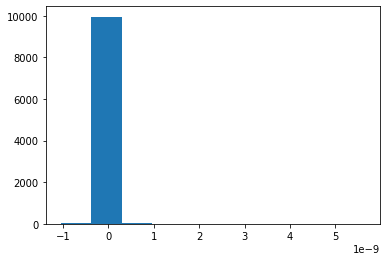

In [11]:
plt.hist(list(map(lambda x:x[0]-x[1],stats[('thing', 'many>few')].values())))

(array([2.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 2.900e+01, 9.929e+03,
        2.700e+01, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([-8.38799243e-10, -6.90393715e-10, -5.41988187e-10, -3.93582659e-10,
        -2.45177131e-10, -9.67716031e-11,  5.16339250e-11,  2.00039453e-10,
         3.48444981e-10,  4.96850509e-10,  6.45256037e-10]),
 <BarContainer object of 10 artists>)

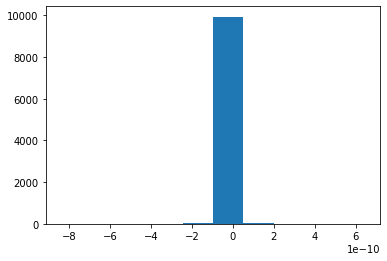

In [12]:
plt.hist(list(map(lambda x:x[0]-x[1],stats[('thing', 'aff>neg')].values())))